In [2]:
import pymeshlab
import numpy as np
import typing
from scipy.optimize import minimize
from numba import jit, njit
import math
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['svg']


In [1041]:
def save_mesh(verts, faces, file_name):
    saving_mesh = pymeshlab.Mesh(verts, faces)
    saving_meshset = pymeshlab.MeshSet()
    saving_meshset.add_mesh(saving_mesh)
    saving_meshset.save_current_mesh(file_name, save_vertex_normal=False, save_vertex_color=False)

# generate bin structure
we generate bins by tesalating a sphere to get the bin centers.
We will use a fibbonacci sphere for this because it has some nice properties:
- very evenly spaced spoints
- arbitrary amount of points
- simple algorithm
- deterministic sequence of points

In [1042]:
@njit
def fibonacci_sphere(n):
    goldenRatio = (1 + 5**0.5)/2
    i = np.arange(0, n)
    theta = 2 * np.pi * i / goldenRatio
    phi = np.arccos(1 - 2*(i+0.5)/n)
    x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)

    return np.column_stack((x,y,z))

# Get radius of bins
We get the radius (in radians) of bins by taking taking the smallest angle between two bin centers.  
We get the smallest distance by brute force which means that with very large number of bins this becomes
extremely computationally expensive.

to get the angle theta between two vectors we use the fact that theta is equal to arccos(a dot b / (|a|*|b|))

In [1043]:
@njit
def get_min_radius(verts):
    min = np.finfo(np.float64).max
    for i in range(len(verts)):
        for j in range(len(verts)):
            if (i != j): # dont compare a point to itself
                a = verts[i]
                b = verts[j]
                # get angle distance
                dist = np.arccos(a @ b)
                if dist < min: min = dist # if this is the smallest so far then update
    return min

# Calculating face normals
Since we want to put all the face normals into their correct bins we first need to calculate each normal of each face.
We do this by doing the cross product way

In [1044]:
@njit
def normalize(vector):
    cp = np.copy(vector)
    return cp / np.linalg.norm(cp)
@njit
def get_face_normals(verts, faces):
    tmp = np.zeros((len(faces), 3), dtype=np.float64)
    #arr = [get_normal(verts, face) for face in faces]
    for i, face in enumerate(faces):
        tmp[i] = get_face_normal(verts, face)
    return tmp
    
@njit
def get_face_normal(verts, face):
    # get vertices
    p1 = verts[face[0]]
    p2 = verts[face[1]]
    p3 = verts[face[2]]

    u = p2 - p1
    v = p3 - p1

    return np.cross(u, v)

# calculate face normal but replace a vertex with a new value
@njit
def get_face_normal_with_vertex_substitution(verts, face, sub_vertex_index, sub_vertex_value):
    # get vertices
    p1 = verts[face[0]] if face[0] != sub_vertex_index else sub_vertex_value
    p2 = verts[face[1]] if face[1] != sub_vertex_index else sub_vertex_value
    p3 = verts[face[2]] if face[2] != sub_vertex_index else sub_vertex_value

    u = p2 - p1
    v = p3 - p1

    return np.cross(u, v)

# Putting the face normals into their bins
We will the face normals into their bins. To prevent that a normal can go into two bins we will find the smallest angle between two bins and half that.
This angle will be the angle angle with the bincenter a face normal must be have to be put in that bin

In [1045]:

def collect_face_normals(bin_centers, face_normals):
    # normalize inputs
    normed_bin_centers = np.copy(bin_centers)
    for i, center in enumerate(normed_bin_centers):
        normed_bin_centers[i] = center / np.linalg.norm(center)

    normed_face_normals = np.copy(face_normals)
    for i, face_normal in enumerate(normed_face_normals):
        normed_face_normals[i] = face_normal / np.linalg.norm(face_normal)

    # get the minimum distance between bin centers and half it
    max_angle = get_min_radius(normed_bin_centers) / 2.0

    # create bins. A list where each element is a list of the indices of the face normals that should go in there.
    # note wierd syntax to instruct numba what the data type is by using "for x in range(0)"
    bins = []
    for i in normed_bin_centers:
        bins.append([np.int64(x) for x in range(0)])

    # for face normal check it it lies less than max_angle away from a bin and if it does put it in that bin.
    for i, face_normal in enumerate(normed_face_normals):
        for j, bin_center in enumerate(normed_bin_centers):
            
            angle = np.arccos(np.dot(face_normal, bin_center))
            if (angle < max_angle): # if angle is smaller than max_angle then put i in bin j
                bins[j].append(i)
                break # since a normal can go in at most one bin we can break
    
    return bins

# deriving coordinates in 2D
After we have the face normals per bin we need to calculate each of their 2d position relative to the bin center.
We do this by apply two rotations to the bin center, first around the x axis and then the y axis, to map the bin center to the z axis.
Applying the inverse of this transformation to the x and the y unit vectors gives us the new bases of our 2d coordinate system for that bin.

## 2nd attempt at explaining how this works
We derive a sequence of to rotations: first by some angle theta around the x axis and second one by some angle gamma around the y axis that will move the bin center to the z axis. This transformation we will call T. By also applying T to the face normals we can effectively get their coordinates in 2D

In [1046]:
@njit
def get_transformation(bin_center):
    x, y, z = bin_center # decompose the input vector
    # find angle to rotate around x axis. opposite angle is y coordinate. adjescent angle is the z coordinate
    theta = np.arctan2(y, z)

    # find angle to rotate around y axis. opposite angle is the x coordinate. adjacent angle is (y**2 + z**2)**0.5
    adjacent = np.sqrt(y**2 + z**2)
    gamma = -np.arctan2(x, adjacent) # notice we have to negate the angle because we want to rotate against right hand rule

    # to get the bin center to the z axis we apply first Rx(theta) then Ry(gamma). So the inverse is first Ry(-gamma) then Rx(-theta)
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    sin_gamma = np.sin(gamma)
    cos_gamma = np.cos(gamma)
   
    rx = np.array(
        [
            [1.0, 0.0, 0.0],
            [0.0, cos_theta, -sin_theta],
            [0.0, sin_theta, cos_theta]
        ], dtype=np.float64
    )
    ry = np.array(
        [
            [cos_gamma, 0.0, sin_gamma],
            [0.0, 1.0, 0.0],
            [-sin_gamma, 0.0, cos_gamma]
        ], dtype=np.float64
    )
    
    return ry @ rx

In [1047]:
# face_normals = get_face_normals(verts, faces) # face normal for face i can be found at facenormals[i]
# bin_centers = fibonacci_sphere(secret_length) # bin center for bin i can be found at bin_centers[i]
# bins = collect_face_normals(bin_centers, face_normals) # the indices of the face normals in bin i are found in bins[i]
# bin_angle_radius = get_min_radius(bin_centers) / 2.0
# bin_projection_matrices = [get_transformation(bin_center) for bin_center in bin_centers] # to project a vector into the bases defined by bin i use bin_projection_matrices[i]

# normal adjacency list
We need to be able to get the face normals of the faces adjacent to point p. For quick access we will create an adjacency list for each vertex in the model. A list of the indices of the faces adjacent to vertex will be found at adjacent_faces[i]

In [1048]:
@njit
def calculate_adjacent_faces_indices(vertices, faces):
    # create the resulting list and populate it with empty lists that will eventually contain the indices of adjacent faces
    res = []
    for i in range(len(vertices)):
        res.append([np.int64(x) for x in range(0)]) # some syntax tricks to indicate to numba what types should be inferred
    
    for index, face in enumerate(faces): # for each face
        for vertex in face: # for each vertex in the face
            # append the current face index to list adjacency list of the current vertex
            res[vertex].append(index)

    return res

In [1049]:
# Get bin idx from face idx
def calculate_face_to_bin_relation(bins, faces):
    res = [-1 for x in range(len(faces))] # each face has in bin -1 initially meaning it not in a bin
    # use our list of bins with their contained face normals to populate this result
    for bin_idx, bin in enumerate(bins):
        for face_idx in bin:
            res[face_idx] = bin_idx
    return res


#Optimization Step
call hierarchy:  
main()  
    optimize_vertex()  
    cost()  
    multidimentional_downhill_simplex()  
        costFunc()  
        cost()  


In [1050]:
def get_2D_coordinates(proj_matrix, vector3D):
    epsilon = 0.01
    projected_vector = proj_matrix @ vector3D
    xp = projected_vector[0]
    yp = projected_vector[1]
    h = projected_vector[2]
    l1 = np.arccos(h)
    l2 = np.sqrt(xp**2.0 + yp**2.0)
    x_ij = 0 if l2 < epsilon else xp * l1 / l2 # not sure why paper wants to do this
    y_ij = 0 if l2 < epsilon else yp * l1 / l2 # not sure why paper does this
    return np.array([x_ij, y_ij])
    

In [1051]:
# get bin center of masses
def calculate_center_of_mass_2D(bins, normalized_normals, projection_matrices_3Dto2D):
    center_of_mass = []
    for bin_idx, bin in enumerate(bins):
        com = np.array([0.0, 0.0])
        count = 0
        for normal_idx in bin:
            normal = normalized_normals[normal_idx]
            proj_matrix = projection_matrices_3Dto2D[bin_idx]
            resulting_2D_coords = get_2D_coordinates(proj_matrix, normal)
            com = com + resulting_2D_coords
            count = count + 1
        if count > 0:
            center_of_mass.append(com / count)
        else:
            center_of_mass.append(com)
    return center_of_mass

In [1052]:
def costs(new_normal_2d, original_normal_2d, bin_number, secret):
    delta_max = 0.3 # maximum normal drift in the x direction
    w1 = 0.4
    w2 = 0.6
    x_ij_new = new_normal_2d[0]
    y_ij_new = new_normal_2d[1]
    x_ij_old = original_normal_2d[0]
    y_ij_old = original_normal_2d[1]
    r_new = np.sqrt(x_ij_new**2.0 + y_ij_new**2.0)
    r_old = np.sqrt(x_ij_old**2.0 + y_ij_old**2.0)
    diff = x_ij_new - x_ij_old if secret[bin_number] == 0 else x_ij_old - x_ij_new
    c1 = np.abs(r_new - r_old)
    c2 = 2 if (np.abs(diff) > delta_max) else delta_max - diff if (0 <= diff) else 1
    c = w1 * c1 + w2 * c2
    return c

In [1053]:
# the cost function to minimize. this is a wrapper for the costs(p) function with some guards
def cost_func_builder(current_p_index, delta, secret, vertices, faces, bin_centers, face_normals, face_number_to_bin_number, bin_radius, projection_matrices, adjacent_faces):
    def cost_func(new_p_value):
        #max_costs = 0
        costs_l = []
        # if search space exceeded return 2, 2 is the max value for costs
        if delta < 0:
            return 2
        
        # a was 5 degrees which is 0.0872665 radians
        a = 0.0872665

        # b was 10 degrees which is 0.174533 radians
        b = 0.174533

        # for all triangle normals (TN) adjacent to p
        for face_idx in adjacent_faces[current_p_index]:
            face = faces[face_idx]
            new_TN = normalize(get_face_normal_with_vertex_substitution(vertices, face, current_p_index, new_p_value)) # new normal calculated new p
            original_TN = face_normals[face_idx]
            original_bin_idx = face_number_to_bin_number[face_idx]

            # calculate difference between the new normal as result of new vertex position and original normal
            angle_diff = np.arccos(original_TN @ new_TN)

            # if TN is not in a bin. This means that original bin is -1
            if original_bin_idx == -1:
                # if difference between actual TN and original TN > a return 2
                if angle_diff > a:
                    return 2.0

            
            # if TN has an original bin.
            if original_bin_idx != -1:
                # if difference between actual TN and original TN > b  return 2.0
                if angle_diff > b:
                    return 2.0
            
                # TN left its original bin return 2
                if np.arccos(bin_centers[original_bin_idx] @ new_TN) > bin_radius:
                    return 2.0

                # if all the constraints pass then we can calculate the actual cost of the face normal
                projection_matrix = projection_matrices[original_bin_idx]
                new_normal_2d = get_2D_coordinates(projection_matrix, new_TN)
                original_normal_2d = get_2D_coordinates(projection_matrix, original_TN)
                c = costs(new_normal_2d, original_normal_2d, original_bin_idx, secret)

                # if c > max_costs:
                #     max_costs = c
                costs_l.append(c)

        return (sum(costs_l) / len(costs_l)) if (len(costs_l) > 0) else 0
    return cost_func

In [1054]:
# given a cost function this will find return an improved position for the vertex p
def multidimentional_downhill_simplex(p_index, delta, vertices, faces, bin_centers, face_normals, face_number_to_bin_number, bin_radius, projection_matrices, secret, adjacent_faces):
    initial_vertex_position = vertices[p_index]
    result = minimize(
        cost_func_builder(p_index, delta, secret, vertices, faces, bin_centers, face_normals, face_number_to_bin_number, bin_radius, projection_matrices, adjacent_faces),
        initial_vertex_position,
        method='nelder-mead',
        options={"maxiter": 30}
        )
    return result['x']

In [1055]:
def optimize_vertex(vertex_number, delta, vertices, faces, bin_centers, face_normals, face_number_to_bin_number, bin_radius, projection_matrices, secret, adjacent_faces):
    # initial_cost = costs(p)
    p_new = multidimentional_downhill_simplex(vertex_number, delta, vertices, faces, bin_centers, face_normals, face_number_to_bin_number, bin_radius, projection_matrices, secret, adjacent_faces)
    vertices[vertex_number] = p_new # update the vertex to the new coordinates

In [1056]:
def embed_watermark(vertices, faces, secret):
    delta = 20 # initial search range
    iterations = 5 # number of iterations
    refinements = 3 #number of refinements

    # copy vertices so that we do not modify the original array
    vertices_new = np.copy(vertices)
    faces_new = np.copy(faces) 


    face_normals = [normalize(x) for x in get_face_normals(vertices_new, faces_new)] # face normal for face i can be found at face_normals[i]
    bin_centers = fibonacci_sphere(len(secret)) # bin center for bin i can be found at bin_centers[i]
    bins = collect_face_normals(bin_centers, face_normals) # the indices of the face normals in bin i are found in bins[i]
    bin_angle_radius = get_min_radius(bin_centers) / 2.0
    bin_projection_matrices = [get_transformation(bin_center) for bin_center in bin_centers] # to project a vector into the bases defined by bin i use bin_projection_matrices[i]
    face_to_bin = calculate_face_to_bin_relation(bins, faces_new)
    center_of_mass = calculate_center_of_mass_2D(bins, face_normals, bin_projection_matrices)
    # adjacency list per vertex
    adjacent_faces = calculate_adjacent_faces_indices(vertices_new, faces) # indices of adjacent faces to vertex i are found in adjacent_faces[i]


    for i in range(iterations):
        for vertex_number in tqdm(range(len(vertices_new))): #tqdm sets up a progress bar
            for j in range(refinements):
                optimize_vertex(
                    vertex_number, 
                    delta, 
                    vertices_new, 
                    faces_new, 
                    bin_centers, 
                    face_normals, 
                    face_to_bin, 
                    bin_angle_radius, 
                    bin_projection_matrices,
                    secret,
                    adjacent_faces
                )
        # delta = delta - 1



    face_normals_new = [normalize(x) for x in get_face_normals(vertices_new, faces_new)]
    com_after = calculate_center_of_mass_2D(bins, face_normals_new, bin_projection_matrices)
    mark = []
    for i in range(len(center_of_mass)):
        if center_of_mass[i][0] < com_after[i][0]:
            mark.append(0)
        else:
            mark.append(1)

    print(mark)
    
    # Return the vertices and faces of the watermarked mesh. We need to also return the original center of masses for each bin which is needed to retrieve the watermark
    return vertices_new, faces_new, center_of_mass


In [1057]:
def retrieve_watermark(vertices, faces, original_centers_of_mass):
    face_normals = [normalize(x) for x in get_face_normals(vertices, faces)] # face normal for face i can be found at face_normals[i]
    bin_centers = fibonacci_sphere(len(original_centers_of_mass)) # bin center for bin i can be found at bin_centers[i]
    bins = collect_face_normals(bin_centers, face_normals) # the indices of the face normals in bin i are found in bins[i]
    bin_projection_matrices = [get_transformation(bin_center) for bin_center in bin_centers] # to project a vector into the bases defined by bin i use bin_projection_matrices[i]
    new_centers_of_mass = calculate_center_of_mass_2D(bins, face_normals, bin_projection_matrices)

    mark = []
    for i in range(len(original_centers_of_mass)):
        if original_centers_of_mass[i][0] < new_centers_of_mass[i][0]:
            mark.append(0)
        else:
            mark.append(1)

    retrieved_string = np.array(mark)

    return retrieved_string

## Randomization attack
A simple randomization attack that moves every vertex a fixed distance a random direction

In [1067]:
def attack_vertices_random(vertices, distance, seed):
    n = len(vertices)
    np.random.seed(seed)
    displacements = [normalize(np.random.rand(3)) * distance for item in vertices]
    res = np.copy(vertices)
    for i in range(n):
        res[i] = res[i] + displacements[i]
    
    return res

# determining if the retrieved watermark is hours
The retrieved watermark is likely not a perfect match. Somebins have likely been flipped however most bins should not hav moved much.
To determine if the retrieved bitstring is in corralated to the secret bitstring we first assume that the two are independant. Our
Null Hypothesis is then that the retrieved bitstring is a random bitstring. If the chance of perceiving at least k matches between the two
bitstrings is less than 1 percent we reject the null hypothesis and therefore believe that the secret did indeed watermark the mesh.

In [1059]:
# calculate the probabilty of getting this result under the null hypothesis. If this probabilty is less than 1% reject the null hypothesis
def calculate_match_probability(secret, retrieved_secret):
    matches = np.array(secret) == np.array(retrieved_secret)
    matching_count = sum(matches)
    n = len(matches)
    # calculate the probability that a random string matches the secret in more than matching_count positions
    probability = sum([math.comb(n, k) for k in range(matching_count, n + 1)]) / 2**n
    return probability

# Experiment

In [1089]:
ms = pymeshlab.MeshSet()
ms.load_new_mesh("bishop.obj")
mesh = ms.current_mesh()

verts = mesh.vertex_matrix() # vertex i is found at verts[i]
faces = mesh.face_matrix() # face i is found at faces[i] and is a numpy array containing 3 indices representing the 3 vertices

secret = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
secret_length = len(secret)
print(secret_length)
# used just for debugging
current_vertex_finger = -1

32


In [1061]:
# embed watermark
# result_vertices, result_faces, original_centers_of_mass = embed_watermark(verts, faces, secret)

In [1062]:

# attacked_vertices = attack_vertices_random(result_vertices, 0.05, 3000)


In [1063]:
# retrieved_string = retrieve_watermark(attacked_vertices, faces, original_centers_of_mass)
# res = calculate_match_probability(secret, retrieved_string)

In [1064]:
def randomization_experiment(vertices, faces, secret, centers_of_mass):
    attack_distances = np.linspace(0, 0.5, 20)
    runs = 20 # how many times the experiment is run for the same distance. should average over these runs
    seed = 5432
    averaged_scores = []
    for dist in tqdm(attack_distances):
        scores = []
        for run in range(runs):
            attacked_vertices = attack_vertices_random(vertices, dist, seed) # randomization attack
            seed = seed + 1 # change seed for next attack
            extracted_secret = retrieve_watermark(attacked_vertices, faces, centers_of_mass)
            score = calculate_match_probability(secret, extracted_secret)
            scores.append(score)

        # add the average of the scores to the list
        averaged_scores.append(sum(scores) / len(scores))
    return (attack_distances, averaged_scores)
        


In [ ]:
embedded_verts, embedded_faces, centers_of_mass = embed_watermark(verts, faces, secret) # first embed the watermark


In [ ]:
distances, scores = randomization_experiment(embedded_verts, embedded_faces, secret, centers_of_mass)

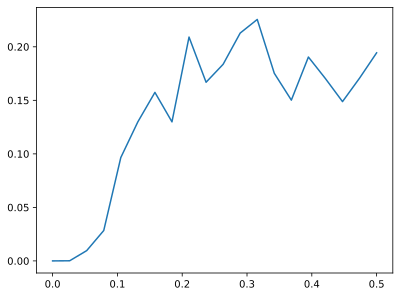

In [ ]:


pyplot.plot(distances, scores)


In [1098]:
def secret_length_experiment(vertices, faces):
    xs = list(range(64, 128, 8)) # the length of the secret
    runs = 5 # how many times the experiment is run for the same distance. should average over these runs
    seed = 5432
    attack_distance = 0.01
    ys = []
    for key_length in tqdm(xs):
        scores = []
        for run in range(runs):
            key = np.ones(int(key_length))
            marked_verts, marked_faces, centers_of_mass = embed_watermark(vertices, faces, key) # first embed the watermark

            attacked_vertices = attack_vertices_random(marked_verts, attack_distance, seed) # randomization attack
            seed = seed + 1 # change seed for next attack
            extracted_secret = retrieve_watermark(attacked_vertices, faces, centers_of_mass)
            score = calculate_match_probability(key, extracted_secret)
            scores.append(score)

        # add the average of the scores to the list
        ys.append(sum(scores) / len(scores))
    return (xs, ys)

In [ ]:
xs, ys = secret_length_experiment(verts, faces)

In [1101]:
ys

[2.4613128152370216e-05,
 1.3753310269125764e-06,
 1.8589254322534538e-07,
 5.321711702864933e-06,
 2.9494822301267367e-05,
 1.4337786063673886e-05,
 1.9933532240097227e-05,
 3.19929274643322e-09]

In [1102]:
# attack distance was 0.01 and all the attacks had different seed. each score is the average over 5 runs
varying_key_lengths2 = [64, 72, 80, 88, 96, 104, 112, 120]
varying_key_length_scores2 = [
    2.4613128152370216e-05,
    1.3753310269125764e-06,
    1.8589254322534538e-07,
    5.321711702864933e-06,
    2.9494822301267367e-05,
    1.4337786063673886e-05,
    1.9933532240097227e-05,
    3.19929274643322e-09]

# attack distance was 0.01 and all the attacks had different seed. each score is the average over 5 runs
varying_key_lengths = [
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63]
varying_key_length_scores = [
    0.03125,
    0.053125,
    0.0078125,
    0.00390625,
    0.001953125,
    0.0009765625,
    0.00048828125,
    0.000244140625,
    0.001708984375,
    0.00185546875,
    0.002410888671875,
    0.0001129150390625,
    7.62939453125e-06,
    3.814697265625e-06,
    9.1552734375e-06,
    0.0005197525024414062,
    0.00023746490478515625,
    0.0005221366882324219,
    2.312660217285156e-06,
    3.219842910766602e-05,
    3.534555435180664e-05,
    1.6987323760986329e-07,
    5.707144737243652e-07,
    6.3978135585784915e-06,
    5.79833984375e-05,
    1.043081283569336e-07,
    6.886199116706848e-06,
    2.2596213966608047e-06,
    3.431783989071846e-06,
    7.705064490437508e-07,
    1.7075217328965664e-07,
    2.865272108465433e-08,
    1.341817551292479e-07,
    5.597226845566183e-07,
    1.0448784451000393e-07,
    1.0138066500076092e-06,
    2.465534635121003e-07,
    2.293745637871325e-09,
    3.1317085813498124e-09,
    5.7911643125407865e-08,
    5.621776608677465e-08,
    1.9252243816936242e-07,
    2.5285731325652706e-06,
    2.1946914834813926e-06,
    1.555259969947542e-05,
    5.711858488410826e-07,
    1.6159703264406744e-07,
    1.3553069635463544e-06,
    4.158851707458666e-09,
    1.8859686095051842e-06,
    5.5357716799431245e-08,
    1.85352950626827e-07,
    4.2466138305136125e-07,
    1.0776873615725435e-08,
    2.589912086181645e-07,
    1.3982240510759802e-06,
    2.9813126864611758e-06,
    7.251385393341548e-06,
    7.612654095823278e-06]

In [1]:
pyplot.plot(varying_key_lengths2 + varying_key_lengths2,varying_key_lengths + varying_key_length_scores2)

NameError: name 'pyplot' is not defined